# Logistic distribution simulation

In [1]:
library(evd)
library(maxstablePCA)
library(ggplot2)
library(dplyr)
library(GGally)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



### setup parameters and simulate data 

In [2]:
set.seed(180424)
s <- 100

In [3]:
X1 <- rmvevd(10000, dep = .2, model = "log", d = 5)
X2 <- rmvevd(10000, dep = .5, model = "log", d = 5)
X3 <- rmvevd(10000, dep = .8, model = "log", d = 5)

In [4]:
X1trafo <- transform_unitpareto(X1)
X2trafo <- transform_unitpareto(X2)
X3trafo <- transform_unitpareto(X3)

# max-stable PCA for X1

In [5]:
summary(apply(X1trafo, 1, max))

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
    1.004     1.577     2.545    13.033     5.274 10000.000 

In [6]:
length(which(apply(X1trafo, 1, max) > s))

[1] 68

In [7]:
maxPCAX1P1 <- max_stable_prcomp(X1trafo, p = 1, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCAX1P2 <- max_stable_prcomp(X1trafo, p = 2, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCAX1P3 <- max_stable_prcomp(X1trafo, p = 3, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCAX1P4 <- max_stable_prcomp(X1trafo, p = 4, s = s, n_initial_guesses = 15000, norm = "linfty")

In [8]:
maxPCAX1P3

$p
[1] 3

$d
[1] 5

$decoder_matrix
          [,1]      [,2]      [,3]
[1,] 1.1983278 0.3386254 0.2152784
[2,] 0.3208609 0.1778669 1.0772608
[3,] 0.7690679 1.0539918 0.5835395
[4,] 1.0171078 0.8233646 0.7043822
[5,] 0.1945241 1.0820849 0.3804263

$encoder_matrix
          [,1]      [,2]      [,3]      [,4]      [,5]
[1,] 0.8344936 0.1346598 0.2889534 0.3004787 0.1445028
[2,] 0.1322362 0.2167687 0.6167587 0.1443989 0.9241454
[3,] 0.2172964 0.9282802 0.2540563 0.2366995 0.2176872

$reconstr_matrix
          [,1]      [,2]      [,3]      [,4]      [,5]
[1,] 0.9999969 0.1998387 0.3462609 0.3600720 0.3129391
[2,] 0.2677564 0.9999999 0.2736849 0.2549870 0.2345059
[3,] 0.6417823 0.5416882 0.6500586 0.2310885 0.9740417
[4,] 0.8487699 0.6538640 0.5078173 0.3056192 0.7609086
[5,] 0.1623291 0.3531422 0.6673853 0.1562519 1.0000038

$loss_fctn_value
[1] 0.5245309

$optim_conv_status
[1] 4

$s
[1] 200

$starting_vals
$starting_vals$decoder_matrix_x0
          [,1]      [,2]      [,3]
[1,] 1.0000000 

In [9]:
estimate_dist <- function(maxpca, n, d, encoded_extr_data) {
    result <- maxpca$loss_fctn_value 
    getxstar <- function(A, b) {
        res <- rep(0, maxpca$p)
        for(j in 1:(maxpca$p)){
            res[j] <- min(b / A[,j])
        } 
        return(res)
    }
                                    
    # determine relevant indices that form basis 
    rowmax <- apply(maxpca$encoder_matrix, 1, max)
    inds <- c()
    for(i in 1:maxpca$p) {
        inds <- c(inds, which(maxpca$encoder_matrix[i,] == rowmax[i])) 
    }
                  
    datinds <- 1:d
    notactiveinds <- datinds[which(!(datinds %in% inds))]
                  
    residmat <- matrix(NA, d - maxpca$p, maxpca$p)
    
    ind <- 1
    for(i in notactiveinds) {
        tmpxstar <- getxstar(maxpca$decoder_matrix[inds, ], maxpca$decoder_matrix[i,])
        tmpapprox <- maxmatmul(maxpca$decoder_matrix[inds,], tmpxstar)
        residmat[ind,] <- maxpca$decoder_matrix[i,] - tmpapprox
        ind <- ind + 1
    }
    if(maxpca$p == 2) return(result)
    
    end <- apply(encoded_extr_data, 1, function(z) z / sum(z))
    return(result + maxpca$s / n * sum(maxmatmul(residmat, end)))
}

In [10]:
estimate_dist(maxPCAX1P3, 10000, 5, t(maxmatmul(maxPCAX1P3$encoder_matrix, t(X1trafo)))[which(rowSums(X1trafo) > s), ])

[1] 0.5245309

In [11]:
round(maxPCAX1P3$decoder_matrix, 2)

1.20,0.34,0.22
0.32,0.18,1.08
0.77,1.05,0.58
1.02,0.82,0.70
0.19,1.08,0.38


In [12]:
round(maxPCAX1P3$encoder_matrix, 2)

0.83,0.13,0.29,0.30,0.14
0.13,0.22,0.62,0.14,0.92
0.22,0.93,0.25,0.24,0.22


In [13]:
round(maxPCAX1P3$reconstr_matrix, 2)

1.00,0.20,0.35,0.36,0.31
0.27,1.00,0.27,0.25,0.23
0.64,0.54,0.65,0.23,0.97
0.85,0.65,0.51,0.31,0.76
0.16,0.35,0.67,0.16,1.00


In [14]:
maxPCAX1P1$loss_fctn_value

[1] 1.065735

### elbow plot and pairplot to visually inspect fit

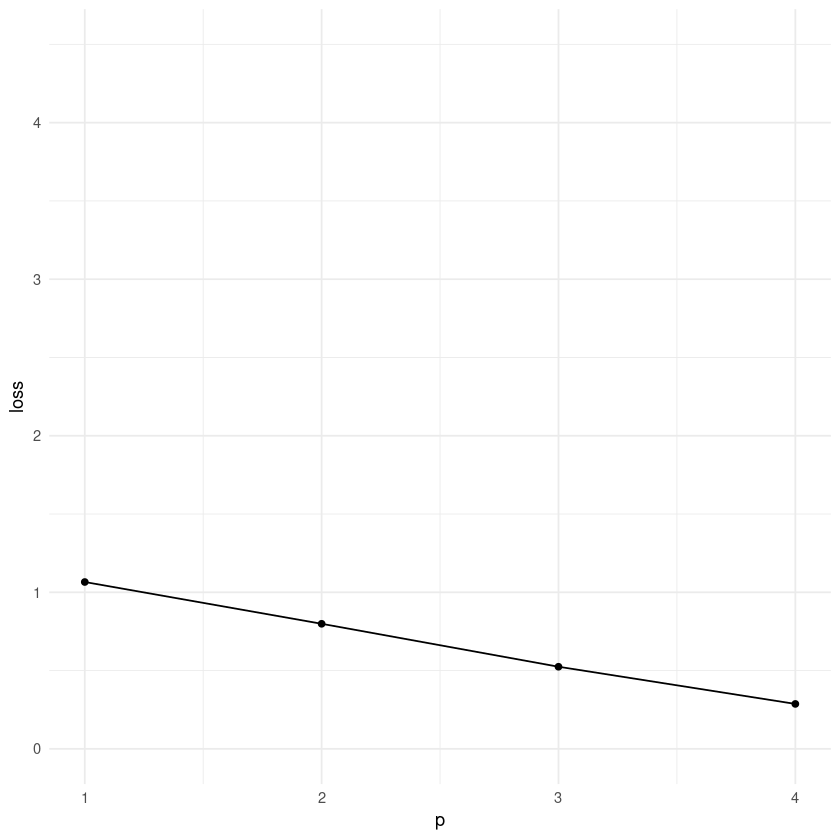

In [15]:
plotlossdatX1 <- data.frame(
    p = 1:4, 
    loss = c(
        maxPCAX1P1$loss_fctn_value, 
        maxPCAX1P2$loss_fctn_value, 
        maxPCAX1P3$loss_fctn_value, 
        maxPCAX1P4$loss_fctn_value

    )
)

pe1 <- ggplot(aes(x = p, y = loss), data = plotlossdatX1) + geom_line() + geom_point() + ylim(0,4.5) + theme_minimal()
pe1

In [16]:
ggsave("logistic_dephigh_elbow.pdf", pe1)

Saving 6.67 x 6.67 in image


In [17]:
rec1 <- t(maxmatmul(maxPCAX1P3$reconstr_matrix, t(exp(X1))))

In [18]:
datX1 <- data.frame(exp(X1))
datX1$is_rec = "original"
datrec1 <- data.frame(rec1)
datrec1$is_rec = "reconstruction"
names(datrec1) <- names(datX1)
plot_datX1 <- full_join(datX1, datrec1)

Joining with `by = join_by(X1, X2, X3, X4, X5, is_rec)`


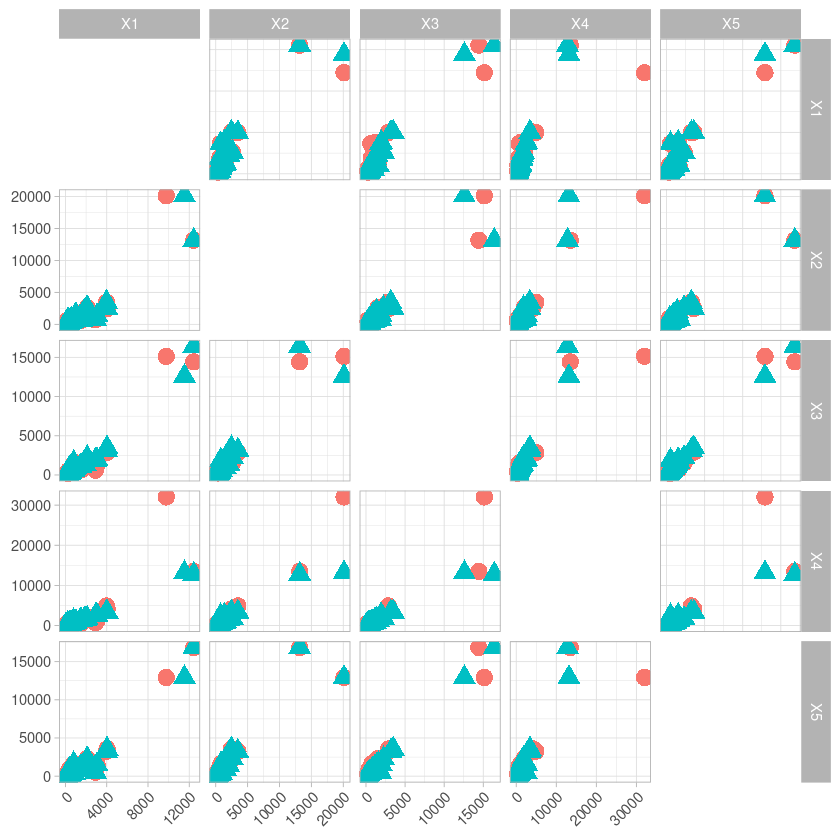

In [19]:
p1 <- ggpairs(
    plot_datX1, 
    aes(color = is_rec, shape = is_rec, size = 2),
    columns = 1:5,
    upper = list(continuous = "points", combo = "dot_no_facet"),
    diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_light() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

p1

In [20]:
ggsave("logistic_dephigh.png", p1)

Saving 6.67 x 6.67 in image


# Max-stable PCA for X2

In [21]:
length(which(apply(X2trafo, 1, max) > s))

[1] 112

In [22]:
maxPCAX2P1 <- max_stable_prcomp(X2trafo, p = 1, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCAX2P2 <- max_stable_prcomp(X2trafo, p = 2, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCAX2P3 <- max_stable_prcomp(X2trafo, p = 3, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCAX2P4 <- max_stable_prcomp(X2trafo, p = 4, s = s, n_initial_guesses = 15000, norm = "linfty")

In [23]:
maxPCAX2P3

$p
[1] 3

$d
[1] 5

$decoder_matrix
            [,1]        [,2]        [,3]
[1,] 0.041504102 0.001421724 1.078428621
[2,] 1.148587798 0.024556866 0.005374643
[3,] 0.007833583 1.248098524 0.001285723
[4,] 0.306146178 0.624052809 0.014835139
[5,] 0.430638190 0.517074235 0.005337646

$encoder_matrix
            [,1]        [,2]        [,3]        [,4]        [,5]
[1,] 0.004598344 0.870634232 0.004441655 0.006686594 0.000595861
[2,] 0.008045389 0.005876178 0.801216596 0.001212154 0.002927268
[3,] 0.927278601 0.043758524 0.003216779 0.001176027 0.001657871

$reconstr_matrix
            [,1]        [,2]        [,3]        [,4]         [,5]
[1,] 1.000003783 0.047190444 0.003469066 0.001268261 0.0017878961
[2,] 0.005281602 0.999999856 0.019675369 0.007680140 0.0006843987
[3,] 0.010041438 0.007334049 0.999997250 0.001512887 0.0036535193
[4,] 0.013756307 0.266541343 0.500001467 0.002047075 0.0018267700
[5,] 0.004949485 0.374928350 0.414288458 0.002879503 0.0015136150

$loss_fctn_value
[1] 1.378

In [24]:
estimate_dist(maxPCAX2P3, 10000, 5, t(maxmatmul(maxPCAX2P3$encoder_matrix, t(X2trafo)))[which(rowSums(X2trafo) > s), ])

[1] 1.872626

In [25]:
round(maxPCAX2P3$decoder_matrix, 2)

0.04,0.00,1.08
1.15,0.02,0.01
0.01,1.25,0.00
0.31,0.62,0.01
0.43,0.52,0.01


In [26]:
round(maxPCAX2P3$encoder_matrix, 2)

0.00,0.87,0.0,0.01,0
0.01,0.01,0.8,0.00,0
0.93,0.04,0.0,0.00,0


In [27]:
round(maxPCAX2P3$reconstr_matrix, 2)

1.00,0.05,0.00,0.00,0
0.01,1.00,0.02,0.01,0
0.01,0.01,1.00,0.00,0
0.01,0.27,0.50,0.00,0
0.00,0.37,0.41,0.00,0


### elbow plot and pairplot to visually inspect fit

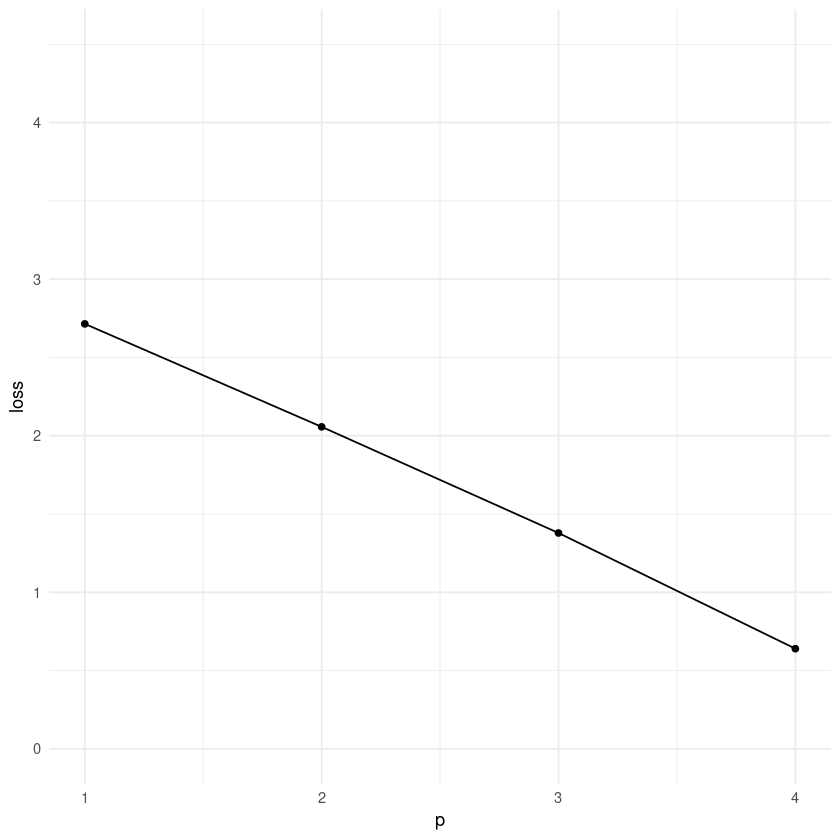

In [28]:
plotlossdatX2 <- data.frame(
    p = 1:4, 
    loss = c(
        maxPCAX2P1$loss_fctn_value,
        maxPCAX2P2$loss_fctn_value,
        maxPCAX2P3$loss_fctn_value,
        maxPCAX2P4$loss_fctn_value

    )
)

pe2 <- ggplot(aes(x = p, y = loss),  data = plotlossdatX2) + geom_line() + geom_point() + ylim(0,4.5) + theme_minimal()
pe2

In [29]:
ggsave("logistic_depmed_elbow.pdf", pe2)

Saving 6.67 x 6.67 in image


In [30]:
rec2 <- t(maxmatmul(maxPCAX2P3$reconstr_matrix, t(exp(X2))))

In [31]:
datX2 <- data.frame(exp(X2))
datX2$is_rec = "original"
datrec2 <- data.frame(rec2)
datrec2$is_rec = "reconstruction"
names(datrec2) <- names(datX2)
plot_datX2 <- full_join(datX2, datrec2)

Joining with `by = join_by(X1, X2, X3, X4, X5, is_rec)`


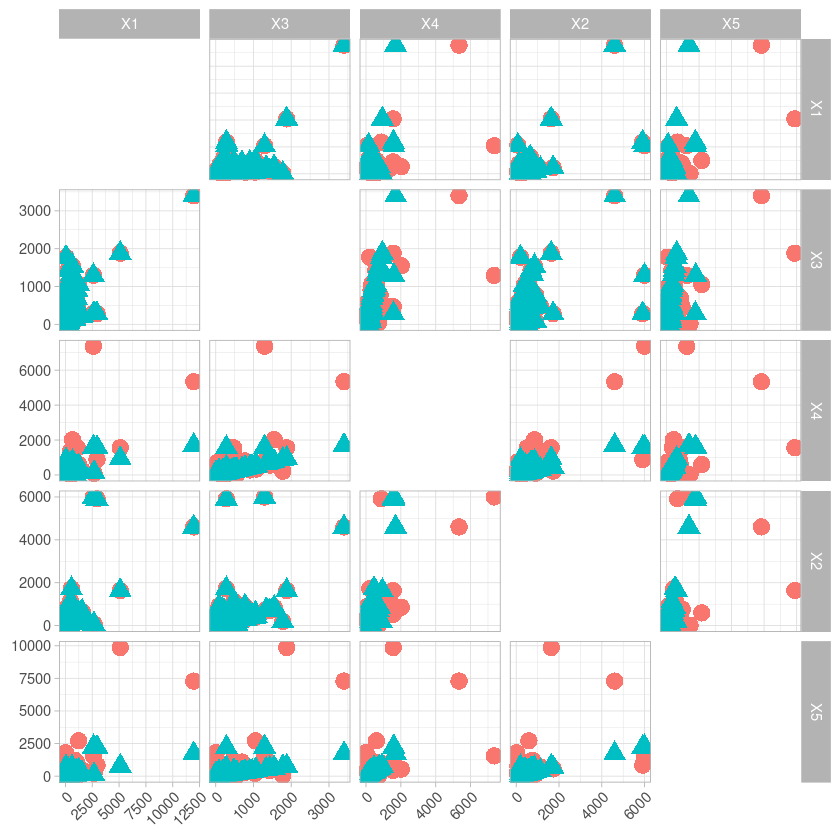

In [32]:
p2 <- ggpairs(
    plot_datX2, 
    aes(color = is_rec, shape = is_rec, size = 2),
    columns = c(1,3,4,2,5),
    upper = list(continuous = "points", combo = "dot_no_facet"),
    diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_light() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

p2

In [33]:
ggsave("logistic_depmed.png", p2)

Saving 6.67 x 6.67 in image


# Same for X3

In [34]:
length(which(apply(X3trafo, 1, max) > s))

[1] 172

In [35]:
maxPCAX3P1 <- max_stable_prcomp(X3trafo, p = 1, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCAX3P2 <- max_stable_prcomp(X3trafo, p = 2, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCAX3P3 <- max_stable_prcomp(X3trafo, p = 3, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCAX3P4 <- max_stable_prcomp(X3trafo, p = 4, s = s, n_initial_guesses = 15000, norm = "linfty")

In [36]:
maxPCAX3P3

$p
[1] 3

$d
[1] 5

$decoder_matrix
             [,1]        [,2]         [,3]
[1,] 0.0117197950 0.299455843 0.0111668514
[2,] 1.6096257363 0.002406571 0.0010663444
[3,] 0.0007099428 0.209242244 0.0112710616
[4,] 0.0032134380 1.628840041 0.0002979067
[5,] 0.0027714839 0.002150189 1.3763767128

$encoder_matrix
             [,1]        [,2]         [,3]         [,4]        [,5]
[1,] 0.0008199627 0.621266802 0.0018131781 0.0006390517 0.001396514
[2,] 0.0003326295 0.001190348 0.0009641684 0.6139256931 0.001048005
[3,] 0.0010410620 0.000800331 0.0007825145 0.0007225733 0.726540724

$reconstr_matrix
             [,1]         [,2]         [,3]        [,4]        [,5]
[1,] 9.960784e-05 0.0072811195 0.0002887259 0.183843636 0.008113172
[2,] 1.319833e-03 1.0000070335 0.0029185382 0.001477456 0.002247865
[3,] 6.960014e-05 0.0004410639 0.0002017448 0.128459190 0.008188885
[4,] 5.418002e-04 0.0019964023 0.0015704760 0.999986751 0.001707033
[5,] 1.432893e-03 0.0017218309 0.0010770348 0.001320056 0.9

In [37]:
estimate_dist(maxPCAX3P3, 10000, 5, t(maxmatmul(maxPCAX3P3$encoder_matrix, t(X3trafo)))[which(rowSums(X3trafo) > s), ])

[1] 1.928508

In [38]:
round(maxPCAX3P3$decoder_matrix, 2)

0.01,0.30,0.01
1.61,0.00,0.00
0.00,0.21,0.01
0.00,1.63,0.00
0.00,0.00,1.38


In [39]:
round(maxPCAX3P3$encoder_matrix, 2)

0,0.62,0,0.00,0.00
0,0.00,0,0.61,0.00
0,0.00,0,0.00,0.73


### elbow plot and pairplot to visually inspect fit

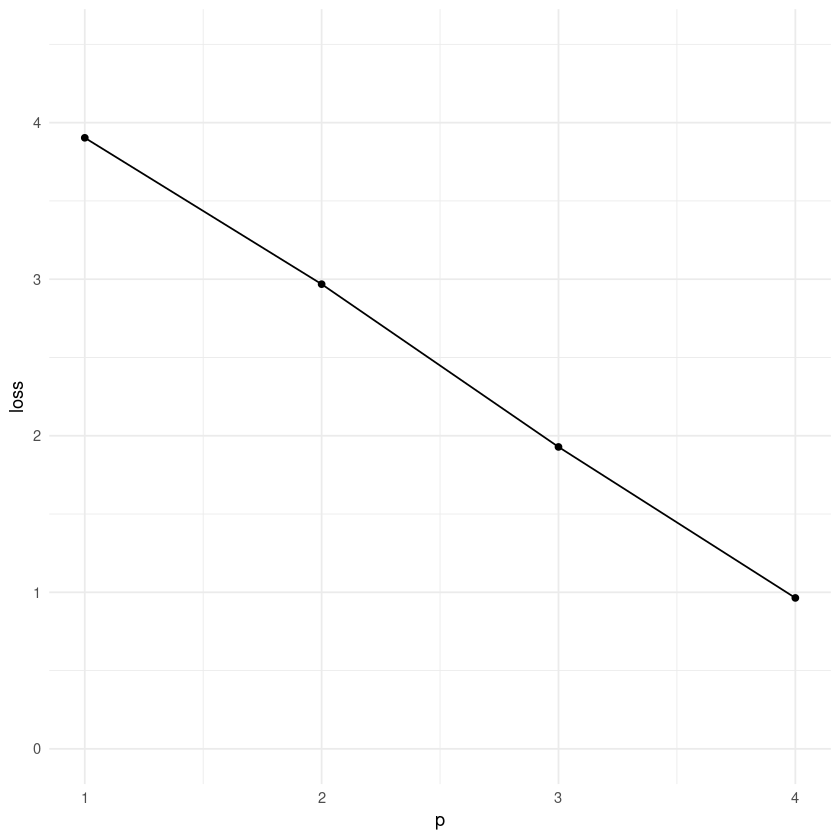

In [40]:
plotlossdatX3 <- data.frame(
    p = 1:4, 
    loss = c(
        maxPCAX3P1$loss_fctn_value,
        maxPCAX3P2$loss_fctn_value,
        maxPCAX3P3$loss_fctn_value,
        maxPCAX3P4$loss_fctn_value

    )
)

pe3 <- ggplot(aes(x = p, y = loss),  data = plotlossdatX3) + geom_line() + geom_point() + ylim(0,4.5) + theme_minimal()
pe3

In [41]:
ggsave("logistic_deplow_elbow.pdf", pe3)

Saving 6.67 x 6.67 in image


In [42]:
rec3 <- t(maxmatmul(maxPCAX3P3$reconstr_matrix, t(exp(X3))))

In [43]:
datX3 <- data.frame(exp(X3))
datX3$is_rec = "original"
datrec3 <- data.frame(rec3)
datrec3$is_rec = "reconstruction"
names(datrec3) <- names(datX3)
plot_datX3 <- full_join(datX3, datrec3)

Joining with `by = join_by(X1, X2, X3, X4, X5, is_rec)`


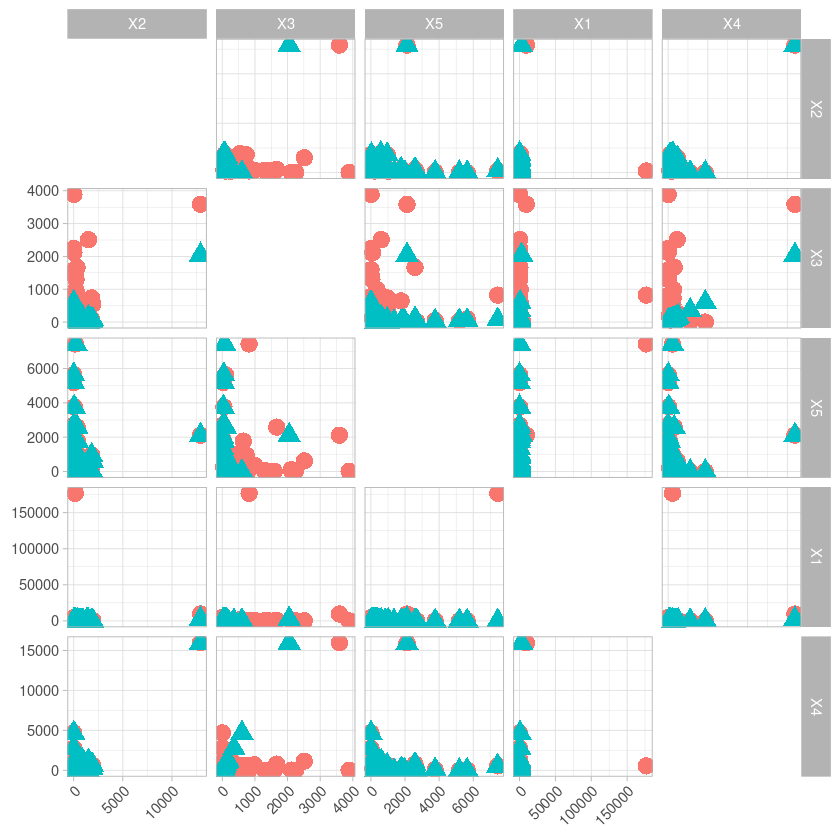

In [44]:
p3 <- ggpairs(
    plot_datX3, 
    aes(color = is_rec, shape = is_rec, size = 2),
    columns = c(2,3,5,1,4),
    upper = list(continuous = "points", combo = "dot_no_facet"),
    diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_light() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

p3

In [45]:
ggsave("logistic_deplow.png", p3)

Saving 6.67 x 6.67 in image


# Comparison to other methods

### PCA for extremes as in Drees/Saubourin

In [46]:
Xsphere1 <- t(apply(X1trafo, 1, function(z) z / sum(z)))
Xsphere1 <- Xsphere1[which(rowSums(X1trafo) > 250), ]
                    
Xsphere2 <- t(apply(X2trafo, 1, function(z) z / sum(z)))
Xsphere2 <- Xsphere2[which(rowSums(X2trafo) > 250), ]   

Xsphere3 <- t(apply(X3trafo, 1, function(z) z / sum(z)))
Xsphere3 <- Xsphere3[which(rowSums(X3trafo) > 250), ]  

In [47]:
specdecomp1 <- eigen(t(Xsphere1) %*% Xsphere1 / 40)
specdecomp1

eigen() decomposition
$values
[1] 1.01002048 0.01882800 0.01802427 0.01462937 0.01203108

$vectors
          [,1]       [,2]       [,3]        [,4]         [,5]
[1,] 0.4466823 -0.5767243  0.6482620  0.04258415 -0.214025716
[2,] 0.4460334 -0.1152953 -0.1137546 -0.19962568  0.857304304
[3,] 0.4443269  0.2846605 -0.1306710 -0.74632577 -0.384011654
[4,] 0.4492704 -0.2925682 -0.6854106  0.41364080 -0.267718972
[5,] 0.4497320  0.6981893  0.2827608  0.47982841  0.009161096


In [48]:
specdecomp2 <- eigen(t(Xsphere2) %*% Xsphere2 / 40)
specdecomp2

eigen() decomposition
$values
[1] 1.0059133 0.1939782 0.1916754 0.1430766 0.1173726

$vectors
           [,1]        [,2]        [,3]       [,4]        [,5]
[1,] -0.4615479  0.75111864  0.01824834  0.4704450  0.03380544
[2,] -0.4294734  0.09691678 -0.06991131 -0.6197883  0.64585964
[3,] -0.4316336  0.07024601 -0.01286785 -0.4805097 -0.76006764
[4,] -0.4474824 -0.46545386 -0.68857165  0.3298154  0.01425278
[5,] -0.4647345 -0.45259930  0.72144502  0.2342567  0.06177827


In [49]:
specdecomp3 <- eigen(t(Xsphere3) %*% Xsphere3 / 40)
specdecomp3

eigen() decomposition
$values
[1] 1.0572489 0.5702383 0.5341022 0.5080381 0.4703668

$vectors
           [,1]         [,2]        [,3]       [,4]        [,5]
[1,] -0.4626536  0.246894670  0.78535259 -0.2711988 -0.18619133
[2,] -0.4832851  0.587391850 -0.37010380  0.4657845 -0.25975806
[3,] -0.4248811 -0.109769256 -0.49428295 -0.7450556 -0.08946101
[4,] -0.4042779 -0.007941992  0.01782500  0.1109038  0.90767775
[5,] -0.4565332 -0.762824667  0.04013887  0.3769462 -0.25685865


Joining with `by = join_by(X1, X2, X3, X4, X5)`


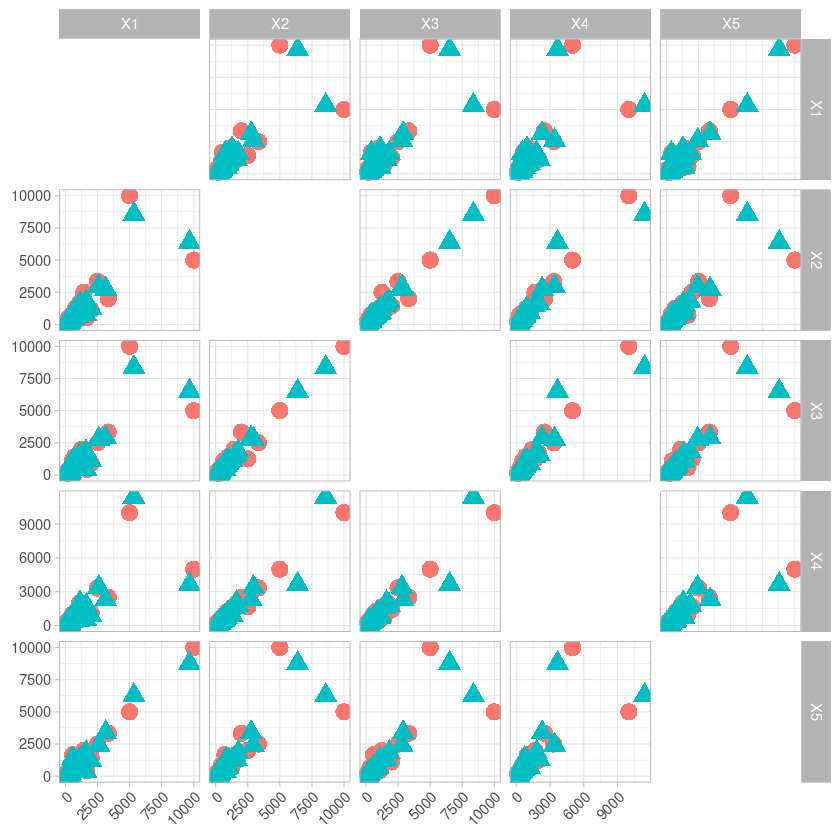

In [50]:
rec1 <- X1trafo %*% specdecomp1$vectors[1:5, 1:3] %*% t(specdecomp1$vectors[1:5, 1:3])

plotdat_DS1 <- data.frame(X1trafo)
tmp <- data.frame(rec1)
plotdat_DS1 <- full_join(plotdat_DS1, tmp)
plotdat_DS1$is_rec <- c(rep(F, 10000), rep(T, 10000))

ggpairs(plotdat_DS1,     
        aes(color = is_rec, shape = is_rec, size = 2),
        columns = 1:5,
        upper = list(continuous = "points", combo = "dot_no_facet"),
        diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_light() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

Joining with `by = join_by(X1, X2, X3, X4, X5)`


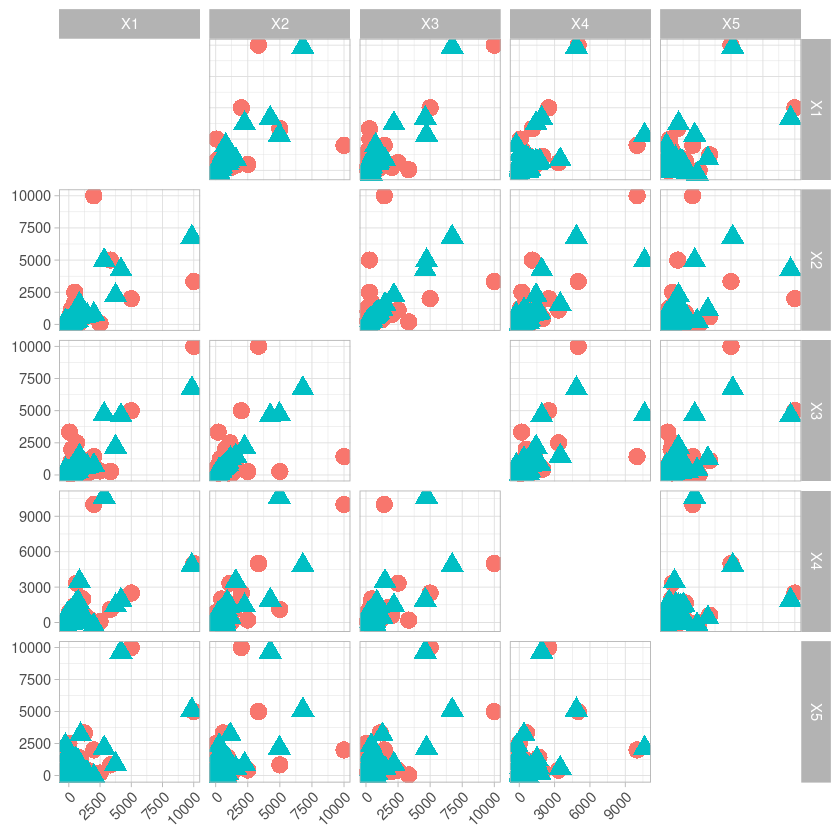

In [51]:
rec2 <- X2trafo %*% specdecomp2$vectors[1:5, 1:3] %*% t(specdecomp2$vectors[1:5, 1:3])

plotdat_DS2 <- data.frame(X2trafo)
tmp <- data.frame(rec2)
plotdat_DS2 <- full_join(plotdat_DS2, tmp)
plotdat_DS2$is_rec <- c(rep(F, 10000), rep(T, 10000))

ggpairs(plotdat_DS2,     
        aes(color = is_rec, shape = is_rec, size = 2),
        columns = 1:5,
        upper = list(continuous = "points", combo = "dot_no_facet"),
        diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_light() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

Joining with `by = join_by(X1, X2, X3, X4, X5)`


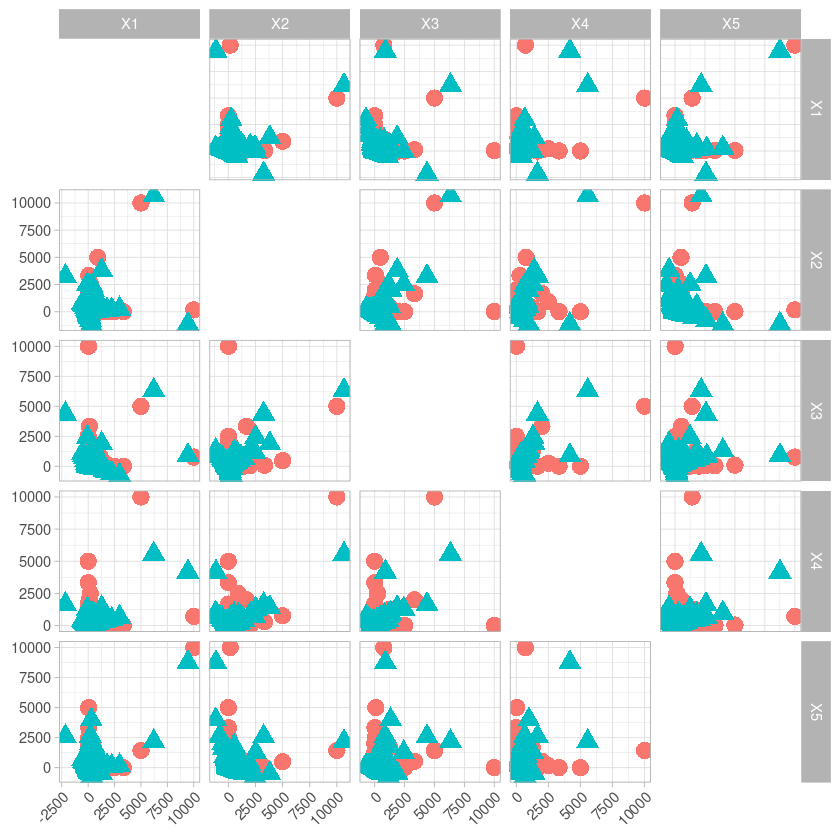

In [52]:
rec3 <- X3trafo %*% specdecomp3$vectors[1:5, 1:3] %*% t(specdecomp3$vectors[1:5, 1:3])

plotdat_DS3 <- data.frame(X3trafo)
tmp <- data.frame(rec3)
plotdat_DS3 <- full_join(plotdat_DS3, tmp)
plotdat_DS3$is_rec <- c(rep(F, 10000), rep(T, 10000))

ggpairs(plotdat_DS3,     
        aes(color = is_rec, shape = is_rec, size = 2),
        columns = 1:5,
        upper = list(continuous = "points", combo = "dot_no_facet"),
        diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_light() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

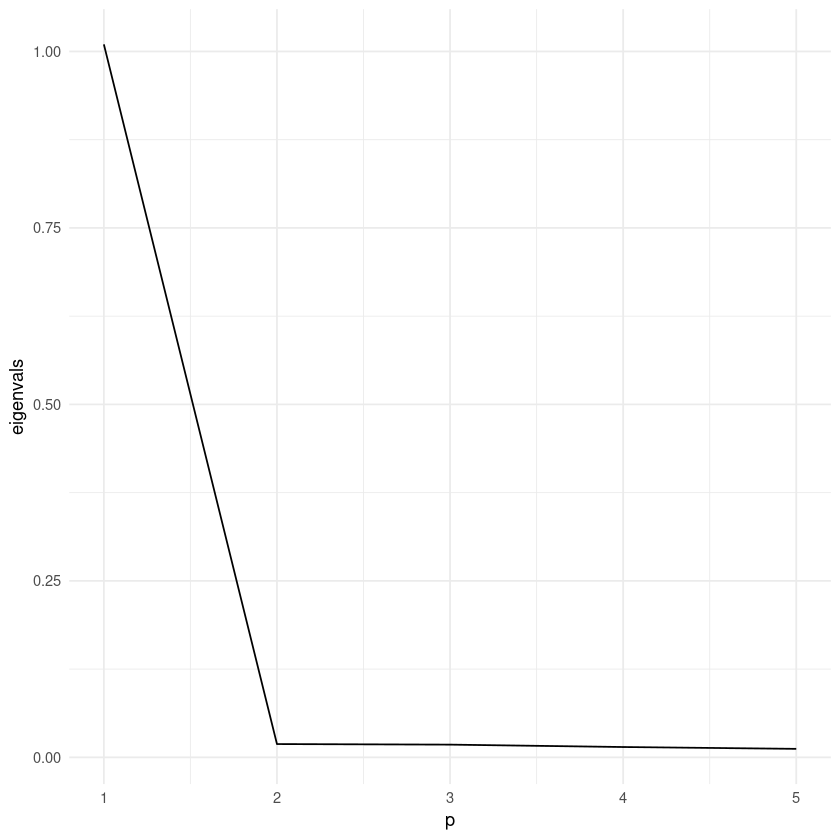

In [53]:
screeplotdat1 <- data.frame(p = 1:5, eigenvals = specdecomp1$values)

ggplot(aes(x = p, y = eigenvals), data = screeplotdat1) + 
geom_line() + 
theme_minimal()

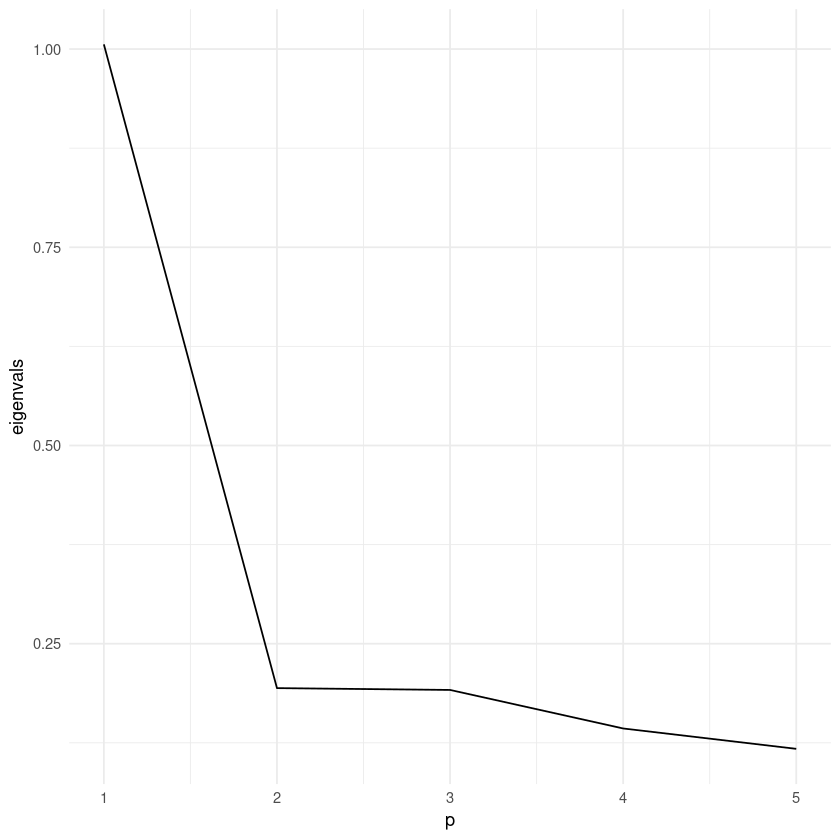

In [54]:
screeplotdat2 <- data.frame(p = 1:5, eigenvals = specdecomp2$values)

ggplot(aes(x = p, y = eigenvals), data = screeplotdat2) + 
geom_line() + 
theme_minimal()

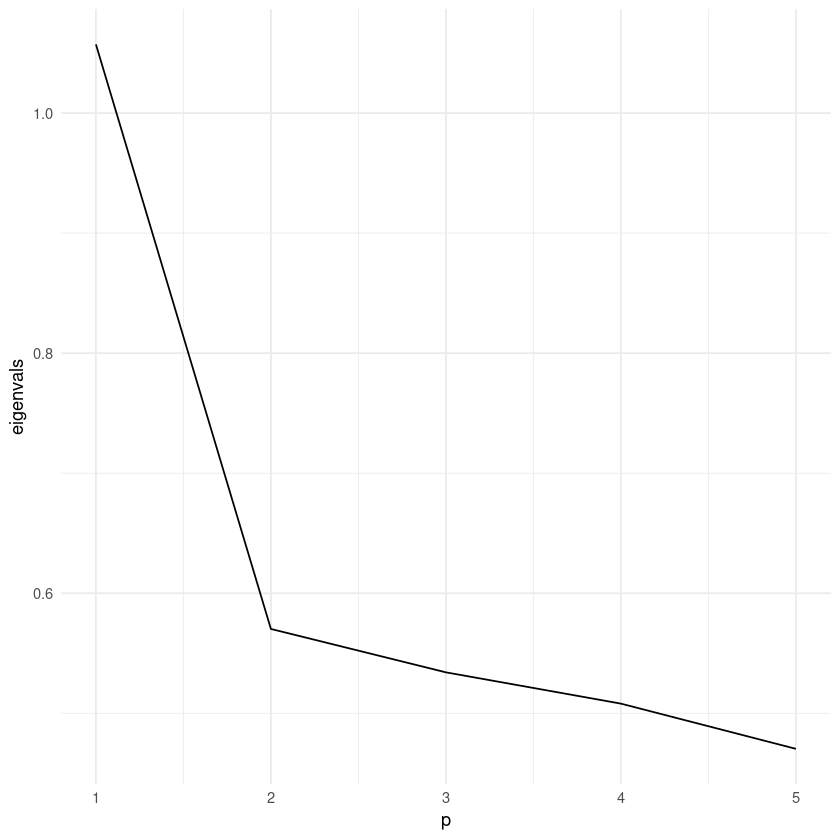

In [55]:
screeplotdat3 <- data.frame(p = 1:5, eigenvals = specdecomp3$values)

ggplot(aes(x = p, y = eigenvals), data = screeplotdat3) + 
geom_line() + 
theme_minimal()

# PCA by Cooley and Thibaud 

In [56]:
# Tail pairwise dependence matrix code by Yiang 

decls <- function(x, th, k) {
    ## Ordinary decluster.
    id.big <- which(x > th)
    id.dif <- diff(id.big)
    tick <- which(id.dif >= k)
    start <- id.big[c(1, tick + 1)]              # Where a new cluster begins
    end <- c(id.big[tick], last(id.big, 1))
    n <- length(start)
    id.res <- rep(0, n)
    for ( i in 1 : n) {
        temp <- x[start[i] : end[i]]
        id.res[i] <- which(temp == max(temp, na.rm = TRUE))[1] + start[i] - 1
    }
    id.res
}

rw.Sigma <- function(X, u = 0.98, decluster = F) {
    ## Compute TPDM
    P <- ncol(X)                      # Number of stations
    M <- nrow(X)                      # Number of obs
    Sigma <- matrix(0, P, P)
    for ( i in 1 : P) {
        if (i %% 5 == 0) print(i)
        for ( j in 1 : P) {
            r <- sqrt(X[, i] ^ 2 + X[, j] ^ 2)
            w1 <- X[, i] / r
            w2 <- X[, j] / r
            th <- quantile(r, u, na.rm = TRUE)
            if(decluster) {
                id <- decls(r, th, 5)
            } else {
                id <- which(r > th)
            } 
            Sigma[i, j] <- sum(w1[id] * w2[id], na.rm = TRUE) / (length(id)) * 2
        }
    }
    Sigma
}

ecdf_shifted <- function(z) length(z) / (length(z) + 1) * ecdf(z)(z) + 1 / (length(z) + 1)

##applies the transformation t
trans <- function(x)
{
    ##because it takes an exponential, this function flakes out if x is too big
    ##hence for big values of x, we return x
    v <- log(1 + exp(x))
    id <- which(x < -20)
    v[!is.finite(v)] <- x[!is.finite(v)]
    v[id] <- exp(x[id])
    return(v)
}

##applies the inverse transformation t^{-1}
invTrans <- function(v)
{
    ##same trickeration for big values of v
    ##still returns -Inf if v is machine zero
    x <- log(exp(v) - 1)
    x[!is.finite(x) & v > 1 & !is.na(x)] <- v[!is.finite(x) & v > 1 &
                                                  !is.na(x)]

    return(x)
}

In [57]:
# Transform data to approximately 2-Fréchet margins 
X1trafo_2frech <- apply(X1trafo, 2, function(z) sqrt(-log(ecdf_shifted(z))))
X2trafo_2frech <- apply(X2trafo, 2, function(z) sqrt(-log(ecdf_shifted(z))))
X3trafo_2frech <- apply(X3trafo, 2, function(z) sqrt(-log(ecdf_shifted(z))))

In [58]:
tpdm1 <- rw.Sigma(X1trafo_2frech)
tpdm2 <- rw.Sigma(X2trafo_2frech)
tpdm3 <- rw.Sigma(X3trafo_2frech)

# tpdm <- nearPD(tpdm)$mat

[1] 5
[1] 5
[1] 5


In [59]:
specdecomp1_cy <- eigen(tpdm1)
specdecomp2_cy <- eigen(tpdm2)
specdecomp3_cy <- eigen(tpdm3)

In [60]:
if(specdecomp1_cy$vectors[1,1] < 0) specdecomp1_cy$vectors[,1] <- -specdecomp1_cy$vectors[,1]
if(specdecomp2_cy$vectors[1,1] < 0) specdecomp2_cy$vectors[,1] <- -specdecomp2_cy$vectors[,1]
if(specdecomp3_cy$vectors[1,1] < 0) specdecomp3_cy$vectors[,1] <- -specdecomp3_cy$vectors[,1]

Saving 6.67 x 6.67 in image


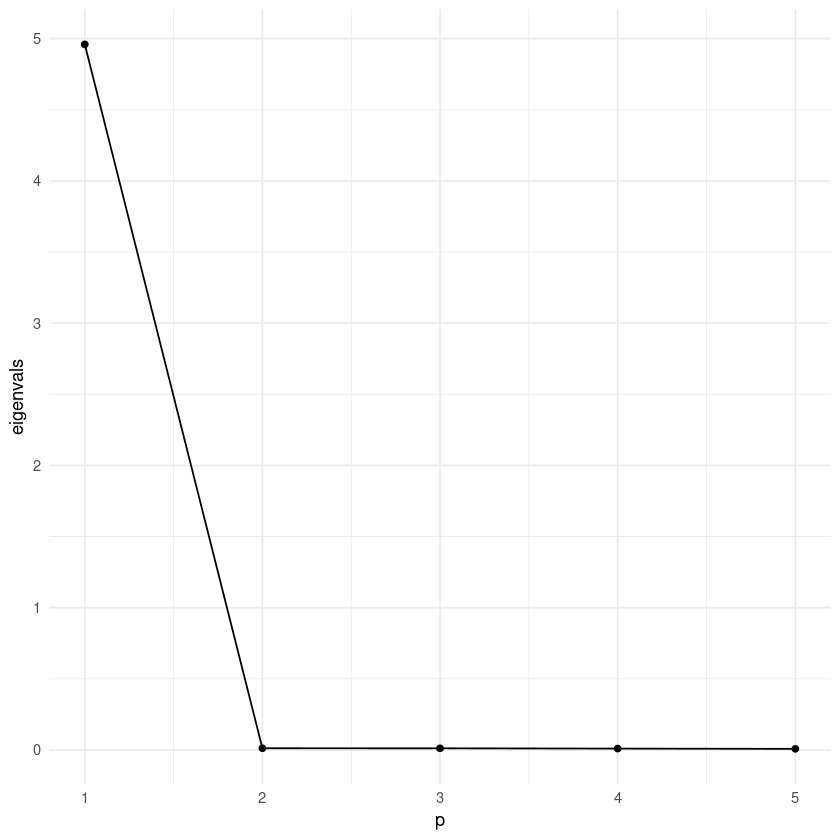

In [61]:
elbow_dat1_cy <- data.frame(p = 1:5, eigenvals = specdecomp1_cy$values)
elbow1_cy <- ggplot(aes(x = p, y = eigenvals), data = elbow_dat1_cy) +
geom_line() + 
geom_point () + 
theme_minimal()

ggsave("elbow_epca_cy_log1.pdf", elbow1_cy)
elbow1_cy

Saving 6.67 x 6.67 in image


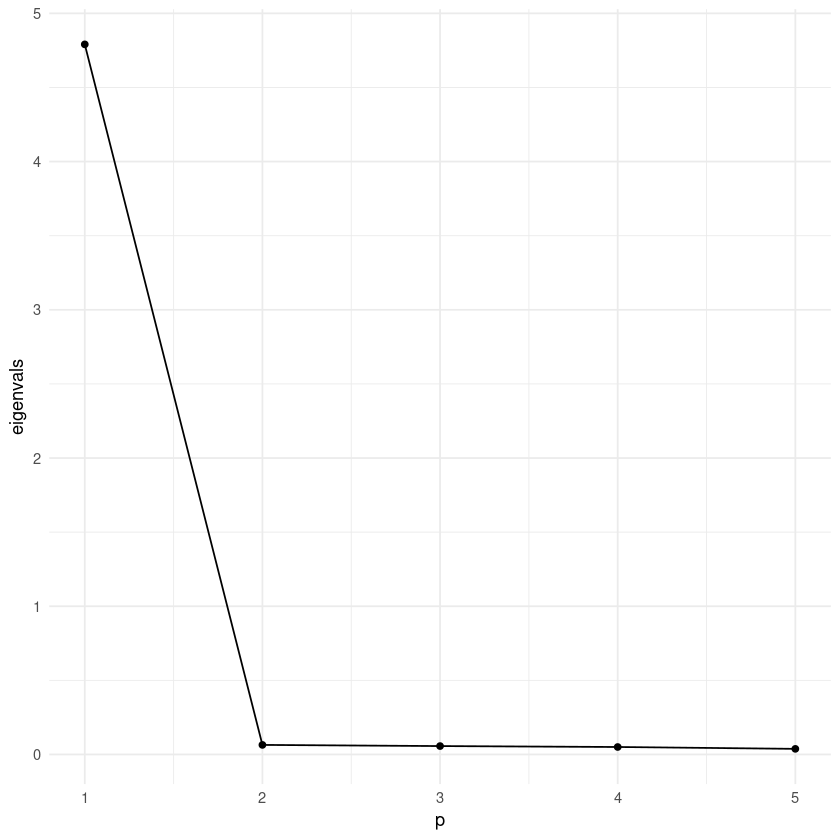

In [62]:
elbow_dat2_cy <- data.frame(p = 1:5, eigenvals = specdecomp2_cy$values)
elbow2_cy <- ggplot(aes(x = p, y = eigenvals), data = elbow_dat2_cy) +
geom_line() + 
geom_point () + 
theme_minimal()

ggsave("elbow_epca_cy_log2.pdf", elbow2_cy)
elbow2_cy

Saving 6.67 x 6.67 in image


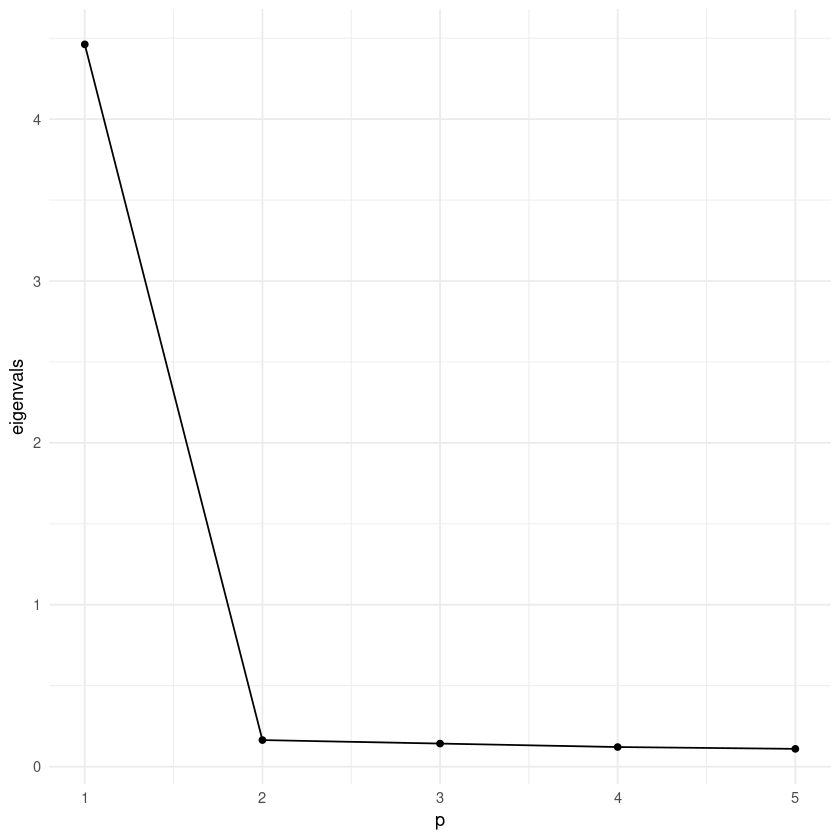

In [63]:
elbow_dat3_cy <- data.frame(p = 1:5, eigenvals = specdecomp3_cy$values)
elbow3_cy <- ggplot(aes(x = p, y = eigenvals), data = elbow_dat3_cy) +
geom_line() + 
geom_point () + 
theme_minimal()

ggsave("elbow_epca_cy_log3.pdf", elbow3_cy)
elbow3_cy

In [64]:
enc1_cy <- t(specdecomp1_cy$vectors[, 1:3]) %*% t(invTrans(X1trafo_2frech))
rec1_cy <- t(specdecomp1_cy$vectors[, 1:3] %*% trans(enc1_cy))

enc2_cy <- t(specdecomp2_cy$vectors[, 1:3]) %*% t(invTrans(X2trafo_2frech))
rec2_cy <- t(specdecomp2_cy$vectors[, 1:3] %*% trans(enc2_cy))

enc3_cy <- t(specdecomp3_cy$vectors[, 1:3]) %*% t(invTrans(X3trafo_2frech))
rec3_cy <- t(specdecomp3_cy$vectors[, 1:3] %*% trans(enc3_cy))

Joining with `by = join_by(X1, X2, X3, X4, X5)`
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing valu

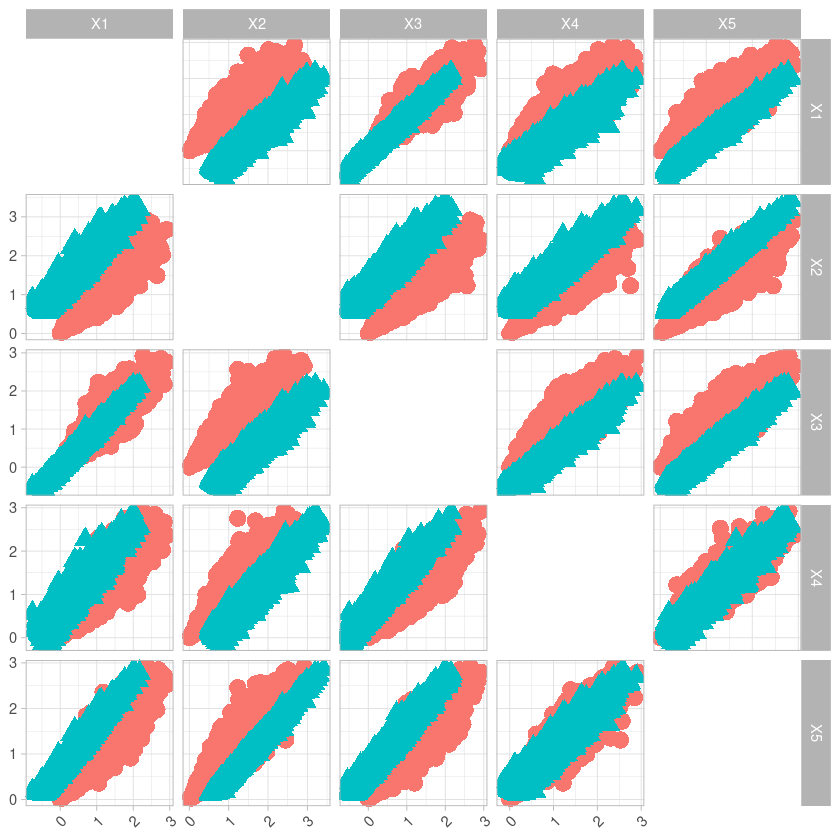

In [65]:
plot_dat1 <- data.frame(X1trafo_2frech)
tmp <- data.frame(rec1_cy)
plot_dat1 <- full_join(plot_dat1, tmp)
plot_dat1$is_rec <- c(rep("False", 10000), rep("True", 10000))


ggpairs(plot_dat1,    
        aes(color = is_rec, shape = is_rec, size = 2),
        columns = 1:5,
        upper = list(continuous = "points", combo = "dot_no_facet"),
        diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_light() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

Joining with `by = join_by(X1, X2, X3, X4, X5)`
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 3 rows containing missing valu

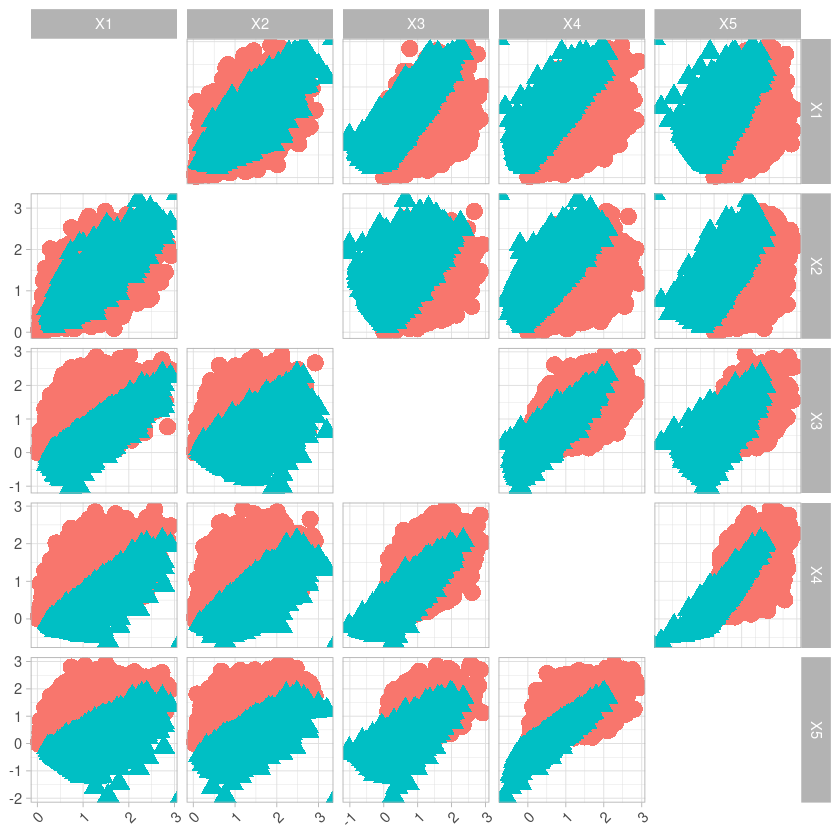

In [66]:
plot_dat2 <- data.frame(X2trafo_2frech)
tmp <- data.frame(rec2_cy)
plot_dat2 <- full_join(plot_dat2, tmp)
plot_dat2$is_rec <- c(rep("False", 10000), rep("True", 10000))


ggpairs(plot_dat2,     
        aes(color = is_rec, shape = is_rec, size = 2),
        columns = 1:5,
        upper = list(continuous = "points", combo = "dot_no_facet"),
        diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_light() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

Joining with `by = join_by(X1, X2, X3, X4, X5)`
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing valu

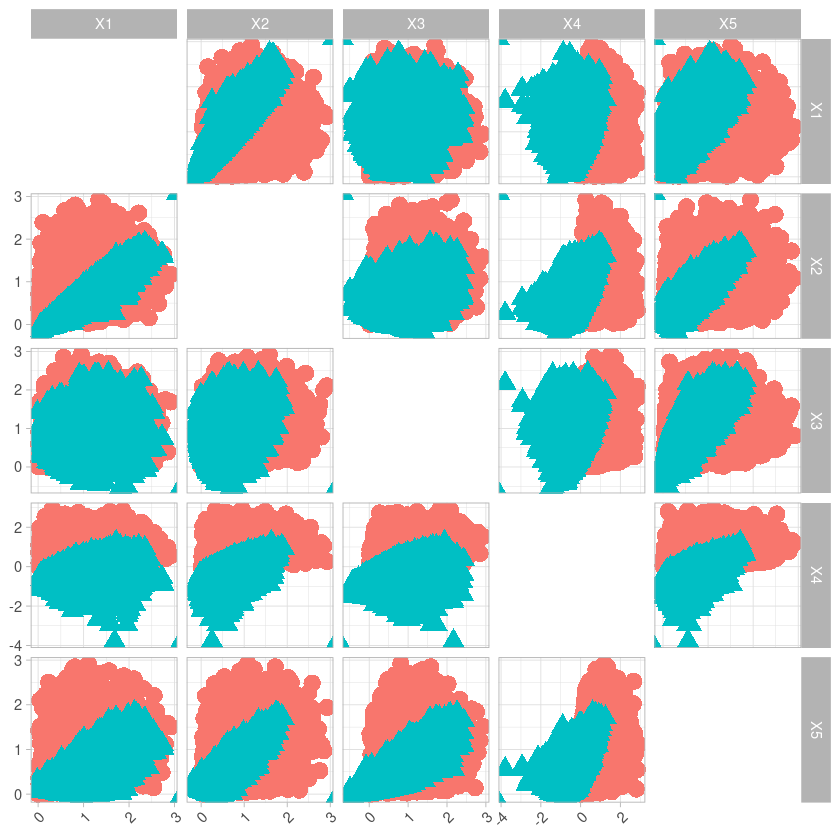

In [67]:
plot_dat3 <- data.frame(X3trafo_2frech)
tmp <- data.frame(rec3_cy)
plot_dat3 <- full_join(plot_dat3, tmp)
plot_dat3$is_rec <- c(rep("False", 10000), rep("True", 10000))


ggpairs(plot_dat3,    
        aes(color = is_rec, shape = is_rec, size = 2),
        columns = 1:5,
        upper = list(continuous = "points", combo = "dot_no_facet"),
        diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_light() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

# Spherical K-means

In [68]:
library(skmeans)

In [69]:
kmeanserrs1 = data.frame(k = 1:5, errs = NA)
kmeansclusterings1 = list()
for(k in 2:5) {
    tmp <- skmeans::skmeans(X1trafo[which(rowSums(X1trafo) > 250), ], k = k)
    kmeansclusterings1[[k]] <- tmp
    kmeanserrs1[k,2] <- tmp$value
}

In [70]:
kmeanserrs2 = data.frame(k = 1:5, errs = NA)
kmeansclusterings2 = list()
for(k in 2:5) {
    tmp <- skmeans::skmeans(X2trafo[which(rowSums(X2trafo) > 250), ], k = k)
    kmeansclusterings2[[k]] <- tmp
    kmeanserrs2[k,2] <- tmp$value
}

In [71]:
kmeanserrs3 = data.frame(k = 1:5, errs = NA)
kmeansclusterings3 = list()
for(k in 2:5) {
    tmp <- skmeans::skmeans(X3trafo[which(rowSums(X3trafo) > 250), ], k = k)
    kmeansclusterings3[[k]] <- tmp
    kmeanserrs3[k,2] <- tmp$value
}

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


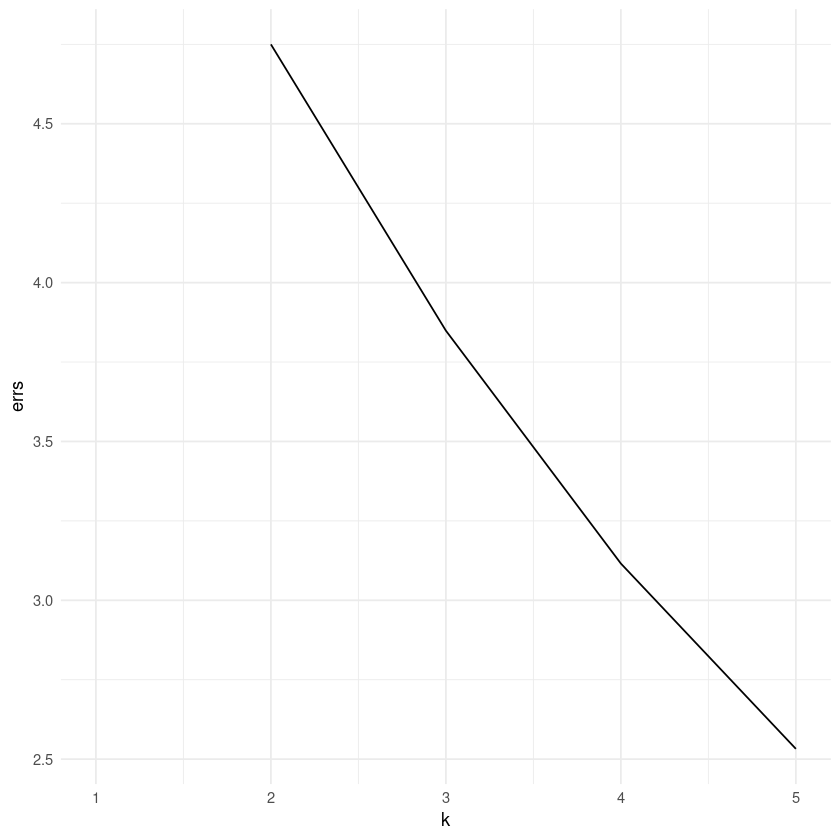

In [72]:
ggplot(aes(x = k, y = errs), data = kmeanserrs1) + 
geom_line() +
theme_minimal()

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


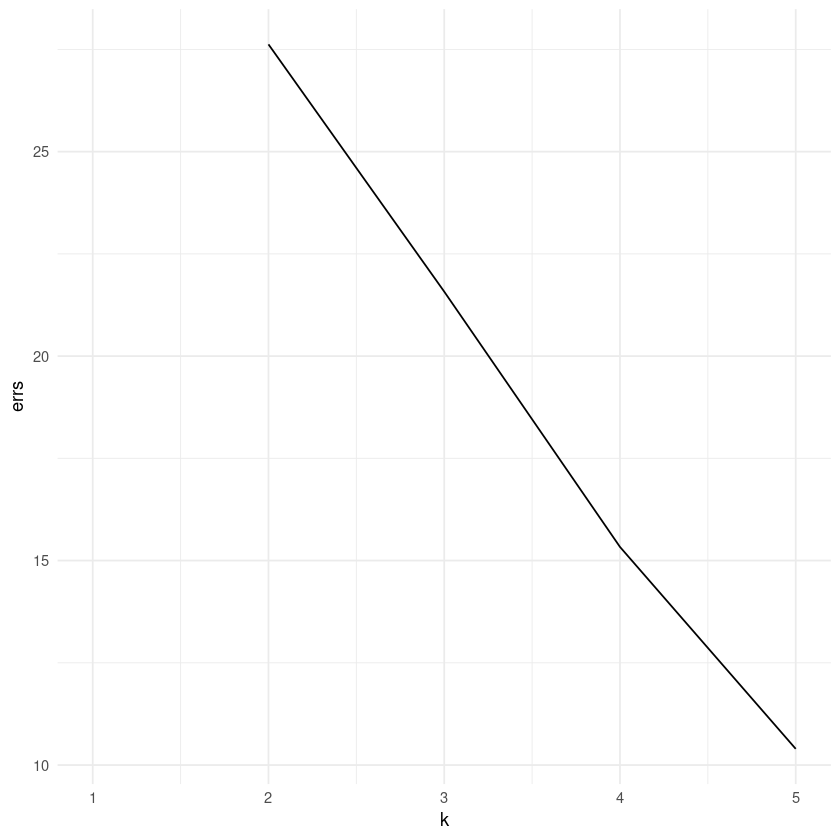

In [73]:
ggplot(aes(x = k, y = errs), data = kmeanserrs2) + 
geom_line() +
theme_minimal()

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


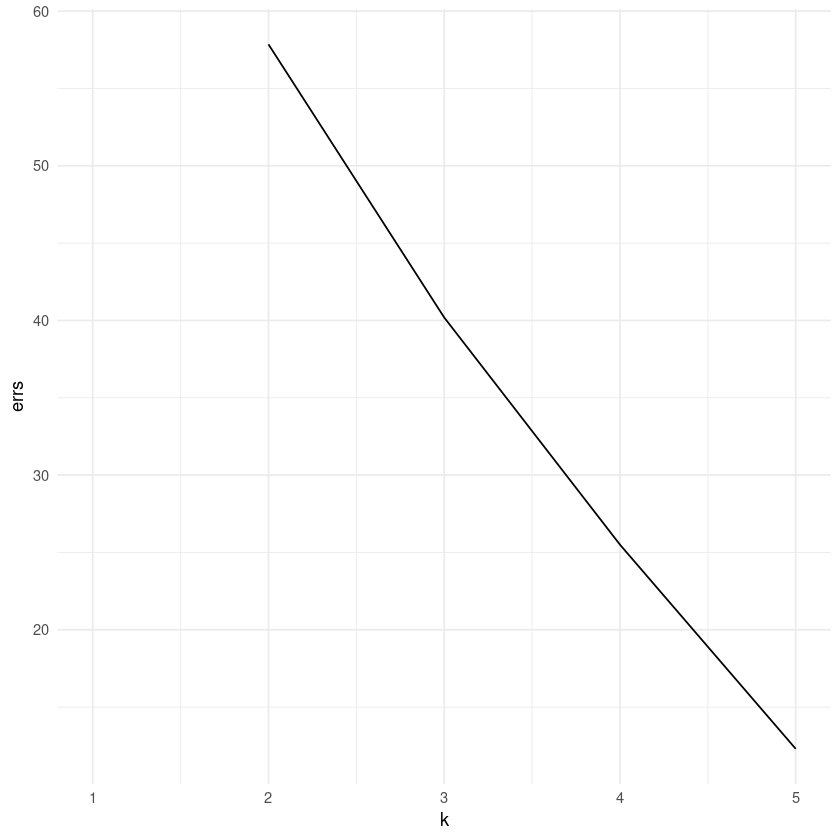

In [74]:
ggplot(aes(x = k, y = errs), data = kmeanserrs3) + 
geom_line() +
theme_minimal()